In [1]:
import sys
sys.path.append('../tools')
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model
import segmentation_models as sm
from keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler
from smooth_tiled_predictions import predict_img_with_smooth_windowing
from segmentation_utils import plot_prediction



CLASSES = {0 : 'background',
           1 : 'Mucosa',
           2 : 'Linfocitos',
           3 : 'Submucosa',
           4 : 'Muscular',
           5 : 'Subserosa',
          }
NUM_CLASSES = 6
BACKBONE = 'resnet34'

TILE_SIZE = 512
DOWNSAMPLE = 10

2021-08-25 13:53:13.398373: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Segmentation Models: using `keras` framework.


In [2]:
os.environ["CUDA_DEVICE_ORDER"]='PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]='1' # Select the GPU 1

gpus = tf.config.list_physical_devices('GPU') # Use only the required GPU memory
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu,True)

2021-08-25 13:53:22.932053: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-25 13:53:29.699604: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3e:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-08-25 13:53:29.699708: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-25 13:53:29.741728: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-25 13:53:29.741866: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-25 13:53:29.755324: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.

In [5]:
scaler = MinMaxScaler()
preprocess_input = sm.get_preprocessing(BACKBONE)

# Same function as training data loading
def preprocess_data(img, mask):
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape) # same as img = (img.astype('float32')) / 255.
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...

    # change mask colors by class labels
    # notice that labels must be consistente with the CLASS dictionary        
    mask=np.where(mask==225, 1, mask) #mucosa=1      #backgroud=0
    mask=np.where(mask==178, 2, mask) #linfocitos=2
    mask=np.where(mask==96,  3, mask) #submucosa=3
    mask=np.where(mask==131, 4, mask) #muscular=4
    mask=np.where(mask==105, 5, mask) #subserosa=5
    #Transform 1 channel labels to hot encoded (NUM_CLASSES channels)
    mask = tf.keras.utils.to_categorical(mask, num_classes=NUM_CLASSES)
    return (img, mask)

model = load_model('trained_models/tiled_unet_d'+str(DOWNSAMPLE)+'_t'+str(TILE_SIZE)+'.hdf5', compile=False)

filename = '10-1960 HEN'  #10-1960, 10-6372, 10-7346
if DOWNSAMPLE==40:
    img = cv2.imread('../../DB/qupath_images/images/img/'+filename+'.jpg') #for downsample=40
    mask = cv2.imread('../../DB/qupath_images/masks/img/'+filename+'.png', 0)
elif DOWNSAMPLE==10:
    #img = cv2.imread('database/images/img/'+filename+'.jpg') #for downsample=10
    #mask = cv2.imread('database/masks/img/'+filename+'.png', 0)
    img = cv2.imread('../tumor_segmentation/database/images/img/10-2266 HET.jpg') #for downsample=10
    mask = cv2.imread('../tumor_segmentation/database/masks/img/10-2266 HET.png', 0)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    # cv2 reads as BGR so must transform to RGB
mask = np.zeros(shape=(10,10,1)) # Use when mask is for Tumor
img, mask = preprocess_data(img, mask)

# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
smooth_prediction = predict_img_with_smooth_windowing(
    img,
    window_size=TILE_SIZE,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=NUM_CLASSES,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)

mask = np.argmax(mask, axis=2)  #hot encoded to 1 channel
final_prediction = np.argmax(smooth_prediction, axis=2)

imgs = np.expand_dims(img, axis=0)  #convert to list for plotting
masks = np.expand_dims(mask, axis=0)
final_predictions = np.expand_dims(final_prediction, axis=0)

  0%|                                                     | 0/8 [00:00<?, ?it/s]2021-08-25 13:57:22.538703: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-25 13:57:22.541588: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2700000000 Hz
2021-08-25 13:57:32.944740: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-25 13:57:34.172828: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8200
2021-08-25 13:57:36.048022: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-25 13:57:37.107778: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
100%|█████████████████████████████████████████████| 8/8 [02:43<00:00, 20.49s/it]


In [ ]:
"""
IOU = MeanIoU(num_classes=NUM_CLASSES)  
# compare groun truth and predicted masks
IOU.update_state(masks, final_predictions)

# calculate I0U for each class...
values = np.array(IOU.get_weights()).reshape(NUM_CLASSES, NUM_CLASSES)

# class_IoU = class true positives / (class true positives +
#                                     class false poitives (same row) +
#                                     class false negatives (same column))
class0_IoU = values[0,0] / (values[0,0] +
                            values[0,1] + values[0,2] + values[0,3] + values[0,4] + values[0,5] +
                            values[1,0] + values[2,0] + values[3,0] + values[4,0] + values[5,0])

class1_IoU = values[1,1] / (values[1,1] +
                            values[1,0] + values[1,2] + values[1,3] + values[1,4] + values[1,5] +
                            values[0,1] + values[2,1] + values[3,1] + values[4,1] + values[5,1])

class2_IoU = values[2,2] / (values[2,2] +
                            values[2,0] + values[2,1] + values[2,3] + values[2,4] + values[2,5] +
                            values[0,2] + values[1,2] + values[3,2] + values[4,2] + values[5,2])

class3_IoU = values[3,3] / (values[3,3] +
                            values[3,0] + values[3,1] + values[3,2] + values[3,4] + values[3,5] +
                            values[0,3] + values[1,3] + values[2,3] + values[4,3] + values[5,3])

class4_IoU = values[4,4] / (values[4,4] +
                            values[4,0] + values[4,1] + values[4,2] + values[4,3] + values[4,5] +
                            values[0,4] + values[1,4] + values[2,4] + values[3,4] + values[5,4])

class5_IoU = values[5,5] / (values[5,5] +
                            values[5,0] + values[5,1] + values[5,2] + values[5,3] + values[5,4] +
                            values[0,5] + values[1,5] + values[2,5] + values[3,5] + values[4,5])


print("Mean IoU using Unet =", IOU.result().numpy())
print('IoU for',CLASSES[0],'is:', class0_IoU)
print('IoU for',CLASSES[1],'is:', class1_IoU)
print('IoU for',CLASSES[2],'is:', class2_IoU)
print('IoU for',CLASSES[3],'is:', class3_IoU)
print('IoU for',CLASSES[4],'is:', class4_IoU)
print('IoU for',CLASSES[5],'is:', class5_IoU)
with np.printoptions(suppress=True):
    print('\n', values)
"""

Masks modified for plotting 6 classes


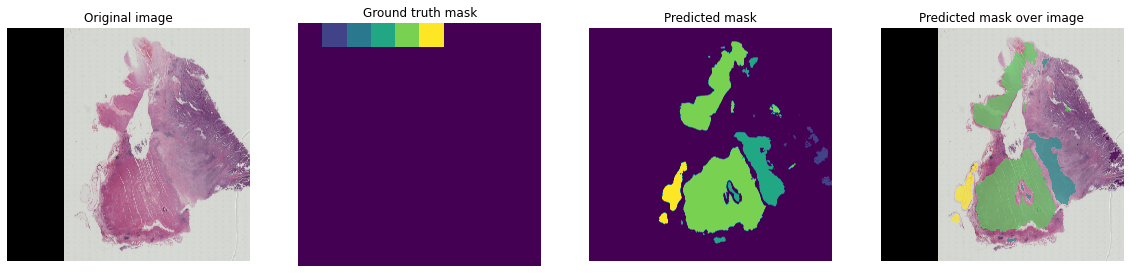

/tmp/ipykernel_202669/3793985197.py:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  f.add_subplot(rows, columns, i)
/tmp/ipykernel_202669/3793985197.py:24: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  f.add_subplot(rows, columns, i)


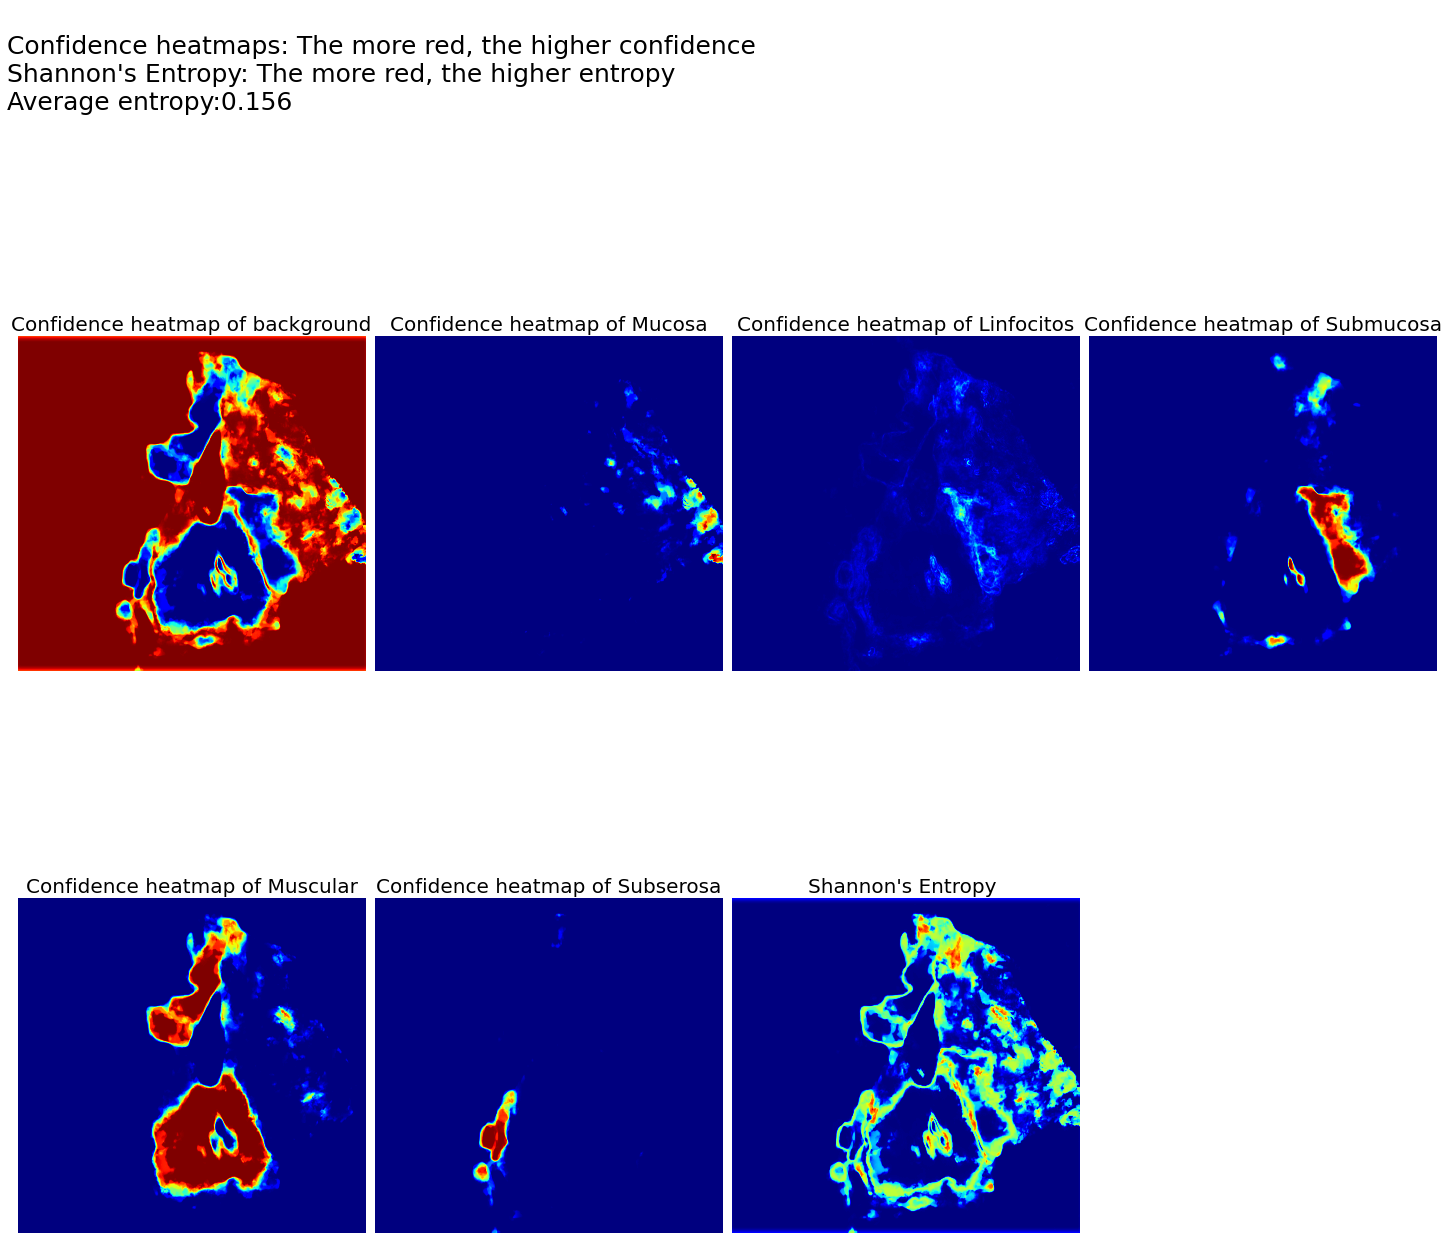

In [6]:
plot_prediction(imgs, masks, final_predictions, NUM_CLASSES, size=20)


f = plt.figure(figsize = (20, 20))

shannon_entr = (-smooth_prediction*np.log2(smooth_prediction)).sum(axis=2)
shannon_entr=np.where(shannon_entr==np.nan, 0, shannon_entr) #mucosa=1      #backgroud=0

plt.suptitle('\nConfidence heatmaps: The more red, the higher confidence' \
             '\nShannon\'s Entropy: The more red, the higher entropy' \
             '\nAverage entropy:'+str(round(np.average(shannon_entr),4))+ \
             '\n\n', x=0, ha='left',fontsize=25)

columns = 4
rows = smooth_prediction.shape[2]/columns+1
i = 1
for channel in range(smooth_prediction.shape[2]):
    f.add_subplot(rows, columns, i)
    plt.title('Confidence heatmap of '+CLASSES[channel], fontsize=20)
    plt.axis('off')
    plt.imshow(smooth_prediction[:,:,channel], cmap='jet')
    i+=1
#https://stackoverflow.com/questions/33607071/fastest-way-to-compute-entropy-of-each-numpy-array-row
f.add_subplot(rows, columns, i)
plt.title('Shannon\'s Entropy ', fontsize=20)
plt.axis('off')
plt.imshow(shannon_entr, cmap='jet')
plt.tight_layout(w_pad=1, h_pad=1)